<a href="https://colab.research.google.com/github/k4404c/tensorflow_workbook/blob/main/tensorflow4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#transfer learning with tensorflow
!nvidia-smi

Sun May 12 22:02:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#get daya (10%)
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-05-12 22:04:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.207, 108.177.96.207, 108.177.119.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.9MB/s    in 4.5s    

2024-05-12 22:04:28 (36.1 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os
for dirpath,dirnames,filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} ")

There are 2 directories and 0 images in 10_food_classes_10_percent 
There are 10 directories and 0 images in 10_food_classes_10_percent/train 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry 
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger 
There are

In [ ]:
#prepare data
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train_data_10 = train_datagen.flow_from_directory(train_dir,
                                                  target_size = IMAGE_SHAPE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                                  target_size = IMAGE_SHAPE,
                                                  batch_size = BATCH_SIZE,
                                                  class_mode = "categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
#setting up callbacks
#tensorboard, modelcheckpoint, earlystopping

#create tensorboard callback
import datetime

def create_tensorboard_callback(dir_name, expiriment_name):
  log_dir = dir_name + '/' + expiriment_name+ '/' + datetime.datetime.now().strftime("%Y%m%d=%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
#Creating models using tensorflow hub
#can access pretrained models on https://tfhub.dev/
#browsing tf hub page and sorting for image classification we saw the following image classification

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"



In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_model(model_url, num_classes=10):

  feauture_extractor_layer = hub.KerasLayer(model_url,
                                                 trainable = False,
                                                 name = "feature_extraction_layer",
                                                 input_shape = IMAGE_SHAPE + (3,))

  model = tf.keras.Sequential([
      feauture_extractor_layer,
      layers.Dense(num_classes, activation = 'softmax', name = "output_layer")

  ])

  return model

In [ ]:
#Creating resnet tf hub feature extraction model

resnet_model = create_model(resnet_url, num_classes = train_data_10.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
resnet_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = "accuracy")

In [ ]:
res_his = resnet_model.fit(train_data_10,
                 epochs=5,
                 steps_per_epoch=len(train_data_10),
                 validation_data=test_data,
                 validation_steps = len(test_data),
                 callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                          expiriment_name="resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/20240512=224319
Epoch 1/5
24/24 [==============================] - 21s 633ms/step - loss: 1.8841 - accuracy: 0.3733 - val_loss: 1.1627 - val_accuracy: 0.6428
Epoch 2/5
24/24 [==============================] - 14s 603ms/step - loss: 0.8658 - accuracy: 0.7533 - val_loss: 0.8409 - val_accuracy: 0.7236
Epoch 3/5
24/24 [==============================] - 11s 491ms/step - loss: 0.6051 - accuracy: 0.8307 - val_loss: 0.7315 - val_accuracy: 0.7600
Epoch 4/5
24/24 [==============================] - 13s 546ms/step - loss: 0.4681 - accuracy: 0.8880 - val_loss: 0.7024 - val_accuracy: 0.7636
Epoch 5/5
24/24 [==============================] - 11s 486ms/step - loss: 0.3753 - accuracy: 0.9160 - val_loss: 0.6646 - val_accuracy: 0.7776


In [ ]:
#our transfer learning feature extracting model outpreformed previous models significantly with les data


In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) #num of epochs

  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

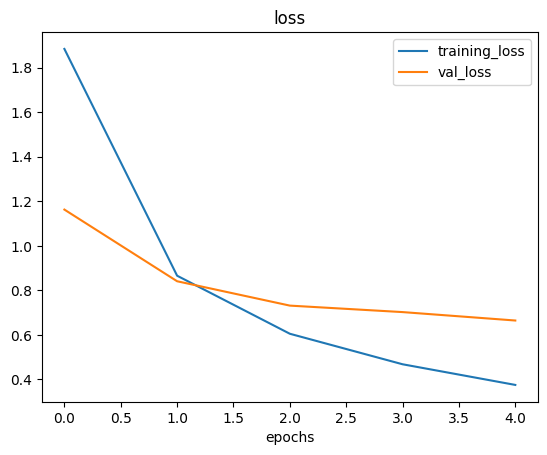

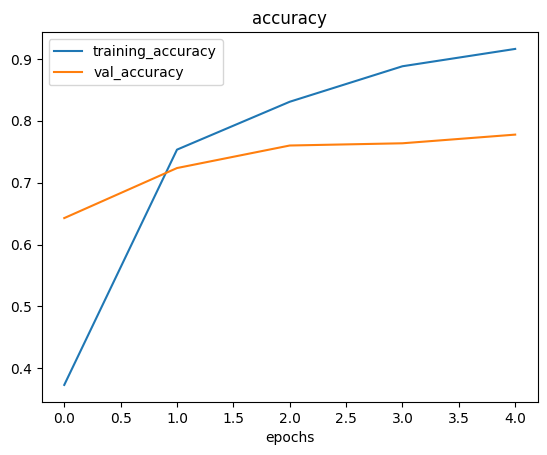

In [ ]:
plot_loss(res_his)

In [ ]:
#EfficientNetV0

In [ ]:
efficient_model = create_model(efficientnet_url, num_classes = train_data_10.num_classes)

In [ ]:
efficient_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
efficient_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(),
                     metrics = "accuracy")

In [ ]:
eff_his = efficient_model.fit(train_data_10,
                 epochs=5,
                 steps_per_epoch=len(train_data_10),
                 validation_data=test_data,
                 validation_steps = len(test_data),
                 callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                          expiriment_name="efficientnet")])

Saving TensorBoard log files to: tensorflow_hub/efficientnet/20240512=225025
Epoch 1/5
24/24 [==============================] - 26s 635ms/step - loss: 1.9056 - accuracy: 0.3840 - val_loss: 1.3428 - val_accuracy: 0.7188
Epoch 2/5
24/24 [==============================] - 11s 452ms/step - loss: 1.0947 - accuracy: 0.7627 - val_loss: 0.8864 - val_accuracy: 0.8164
Epoch 3/5
24/24 [==============================] - 11s 458ms/step - loss: 0.7704 - accuracy: 0.8213 - val_loss: 0.7090 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 11s 460ms/step - loss: 0.6158 - accuracy: 0.8587 - val_loss: 0.6186 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 11s 454ms/step - loss: 0.5216 - accuracy: 0.8787 - val_loss: 0.5624 - val_accuracy: 0.8652


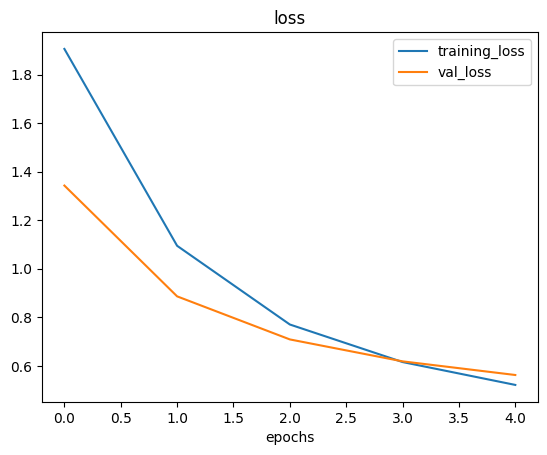

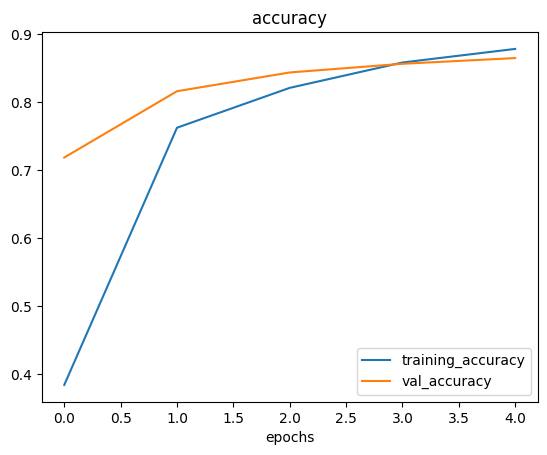

In [ ]:
plot_loss(eff_his)

In [ ]:
#kinds of transfer learning:
# - Original Model (using original on ur own dataset)
# - Feature Extraction (modifying the output layer to deal with your desired classes)
# - Fine Tuning (allowing models layers to be trainable, thus modifying the weights as well as output layer)

In [ ]:
len(efficient_model.layers[0].weights) #number of layers

309